# Perkenalan

##**PERKENALAN**

**MILESTONES 2**

**BY : DENNIS HERDIAWAN**

**BATCH : 004**

**MATERI : Computer Vision (Image Classifications)**

**Milestones 2 ini dibuat guna mengevaluasi Pembelajaran Phase 2 :**

* Mampu memahami konsep Computer Vision/NLP.
* Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
* Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
* Mampu menganalisis dan menjelaskan layer yang dibuat

> Tujuan dari milestone ini adalh untuk membuat sebuah model dengan akurasi tinggi dengn menggunkan bsae model dan praktik atas transfer learning dari VGG16 

# Library

In [1]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data Loading

In [2]:
train_folder=r'train/'
val_folder=r'validation/'
test_folder=r'test/'

In [3]:
import pathlib
data_dir = pathlib.Path(train_folder)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1452


In [4]:
datval = pathlib.Path(val_folder)
image_count1 = len(list(datval.glob('*/*.jpg')))
print(image_count1)

154


In [5]:
dattest = pathlib.Path(test_folder)
image_count2 = len(list(dattest.glob('*/*.jpg')))
print(image_count2)

153


## Penentuan dataset dan ukuran file yang akan di train

In [6]:
IMG_WIDTH=317
IMG_HEIGHT=167
IMG_SIZE=(IMG_HEIGHT, IMG_WIDTH)
batch_size=4

konsideran :
* ukuran file akan di resize menjadi 317x167 untuk keseragaman seluruh dataset dan mempersingkat waktu train
* jumbal batch_size 4 dinilai telah optimal sesuai dengan size dari data train

In [7]:
train_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE
    )

Found 1523 files belonging to 8 classes.


In [8]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 160 files belonging to 8 classes.


# Eksplorasi Data

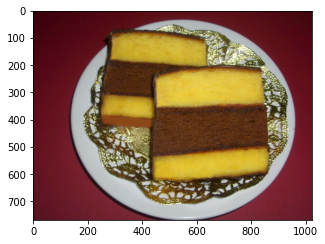

In [9]:
pic = imageio.imread('train/kue_lapis/5.jpg')
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [10]:
print('Tipe data : ' , type(pic)) 
print('Image Shape : {}'.format(pic.shape)) 
print('Image Hight : {}'.format(pic.shape[0])) 
print('Image Width : {}'.format(pic.shape[1])) 
print('Dimension : {}'.format(pic.ndim))

Tipe data :  <class 'imageio.core.util.Array'>
Image Shape : (768, 1024, 3)
Image Hight : 768
Image Width : 1024
Dimension : 3


# Data Preprocessing

In [11]:
class_names = train_dataset.class_names
print(class_names)

['kue_dadar_gulung', 'kue_kastengel', 'kue_klepon', 'kue_lapis', 'kue_lumpur', 'kue_putri_salju', 'kue_risoles', 'kue_serabi']


In [12]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 167, 317, 3)
(4,)


## Autotune data Train dan Val

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(99).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

> dilakukan proses autotune pada buffer_size untuk memastikan tidak terjadi bottleneck pada saat proses training dan validasi

## Rescale data value

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model

## Base Model

In [16]:
keras.backend.clear_session()

In [17]:
np.random.seed(69)
tf.random.set_seed(69)

### Data Augmentation layer

In [18]:
img_aug = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

> layer imaage augmentation ini aakan di berikan kepada seluruh model, dikarenakan tidak adanya proses shuffling ulang atau data baru pada data train dan validation, maka image augmenntation diberlakukan sama pada setiap model 

In [19]:
num_classes = 8

model = Sequential([
    img_aug,
    layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

Pertimbangan pemilihan Activation :
* Relu dipilih dikarenakan performance yang cepat secara komputasi (faktor utama) dan terbukti baik dalam mengelola segala jenis dataset
* dilakukan pemilihn neuron kelipaatan 2 dengan dimulai dari 16 dengan menggunakan 3 dimensi (RGB) dari masing masing daataset
* untuk menghindari overfitting diberlakukan dropout pada layer terakhir

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Pertimbangan pemilihan optimizer :
* Adam dipilih dikarenakan proses komputasi yang relatif efisien dengan learning rate 0.0001 agar dapat menekan loss pada saat proses learning
* loss function yang dipilih adalah SparseCategoricalCrossentropy dikarenakan target multi label (4 class), from logits di set menjadi true agar dapat terbaca sebagai logit tensor dan bukan angka distribusi probabilitas

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 167, 317, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 167, 317, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 158, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 158, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 79, 32)       0         
 2D)                                                  

### Setup Early Stoping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)

> early stopping dipilih 20 (10% dari angka total epoch) agar memberikan ruang kepada model untuk memberikan gambaran fluktuasi haasil train per epoch, tujuannya agar dapat terlihat performanace asli dari dataset untuk mendapatkan model yang robust

In [23]:
epochs=10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[es],
)

Epoch 1/10
381/381 [==============================] - 13s 14ms/step - loss: 14.5953 - accuracy: 0.2364 - val_loss: 2.1112 - val_accuracy: 0.2625
Epoch 2/10
381/381 [==============================] - 5s 12ms/step - loss: 2.0115 - accuracy: 0.2843 - val_loss: 1.8300 - val_accuracy: 0.3313
Epoch 3/10
381/381 [==============================] - 5s 12ms/step - loss: 1.8027 - accuracy: 0.3283 - val_loss: 1.7211 - val_accuracy: 0.3625
Epoch 4/10
381/381 [==============================] - 5s 12ms/step - loss: 1.6917 - accuracy: 0.3769 - val_loss: 1.6041 - val_accuracy: 0.4125
Epoch 5/10
381/381 [==============================] - 5s 12ms/step - loss: 1.6022 - accuracy: 0.4117 - val_loss: 1.5307 - val_accuracy: 0.4250
Epoch 6/10
381/381 [==============================] - 5s 12ms/step - loss: 1.5286 - accuracy: 0.4334 - val_loss: 1.4892 - val_accuracy: 0.4062
Epoch 7/10
381/381 [==============================] - 5s 12ms/step - loss: 1.4542 - accuracy: 0.4655 - val_loss: 1.4101 - val_accuracy: 0.51

## Base Model Evaluation

### Classification report Matrix

In [24]:
from sklearn.metrics import classification_report

In [25]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 160 images belonging to 8 classes.


In [26]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [27]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

                  precision    recall  f1-score   support

kue_dadar_gulung       0.52      0.80      0.63        20
   kue_kastengel       0.64      0.41      0.50        22
      kue_klepon       0.73      0.80      0.76        20
       kue_lapis       0.35      0.30      0.32        20
      kue_lumpur       0.41      0.35      0.38        20
 kue_putri_salju       0.64      0.78      0.70        18
     kue_risoles       0.56      0.75      0.64        20
      kue_serabi       0.60      0.30      0.40        20

        accuracy                           0.56       160
       macro avg       0.56      0.56      0.54       160
    weighted avg       0.56      0.56      0.54       160



### Result Per Epoch

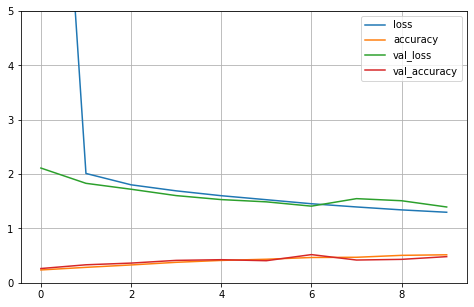

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()

> loss padaa validasi  maasih menunjukan skor yaang tinggi menandakan model masih belum cukup baik dalam melakukan prediksi walaupunn antar class telah memberikan akurasi yang cukup baik 

## Model Inference Base Model

### Fungsi untuk model inference

In [29]:
def pred_infer(image, img_height, img_width):
    img = keras.preprocessing.image.load_img(image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    print(f"Kayaknya hasilnya {class_names[np.argmax(score)]} persentasenya {np.max(score) * 100} %")
    return img

Kayaknya hasilnya kue_klepon persentasenya 82.5964629650116 %


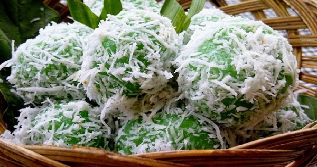

In [30]:
pred_infer('inference/klepon_1.jpg',IMG_HEIGHT, IMG_WIDTH)

## Transfer Learning with VGG16

In [31]:
keras.backend.clear_session()

In [32]:
np.random.seed(69)
tf.random.set_seed(69)

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

## Data Preprocessing

In [34]:
train_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE
    )

Found 1523 files belonging to 8 classes.


In [35]:
train_dataset

<BatchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

In [36]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 160 files belonging to 8 classes.


In [37]:
val_dataset

<BatchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

In [38]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

In [39]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 32
Number of test batches: 8


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
train_dataset

<PrefetchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

### Image Augmentation

In [42]:
img_aug = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [43]:
IMG_SHAPE = IMG_SIZE + (3,)

In [44]:
IMG_SHAPE

(167, 317, 3)

In [45]:
model_vgg16 = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

> Base Model VGG16 dengan weight imagenet

In [46]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_vgg16(image_batch)
print(feature_batch.shape)

(4, 5, 9, 512)


In [47]:
model_vgg16.trainable = False

In [48]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 167, 317, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 167, 317, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 167, 317, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 83, 158, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 83, 158, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 83, 158, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 41, 79, 128)       0     

In [49]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = img_aug(inputs)
x = model_vgg16(x, training=False)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(8)(x)
model = tf.keras.Model(inputs, outputs)

> tambahan base model setelah layer VGG16 untuk proses transfer learning

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 167, 317, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 167, 317, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 9, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 9, 16)          73744     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 5, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 5, 32)          4640      
                                                             

In [52]:
len(model.trainable_variables)

10

In [53]:
val_dataset

<PrefetchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

In [54]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_dataset)

32/32 [==============================] - 3s 29ms/step - loss: 8.5875 - accuracy: 0.1406


In [55]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.59
initial accuracy: 0.14


In [56]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)


In [57]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks=[es],)

Epoch 1/20
381/381 [==============================] - 16s 40ms/step - loss: 2.5557 - accuracy: 0.2003 - val_loss: 1.8520 - val_accuracy: 0.2891
Epoch 2/20
381/381 [==============================] - 14s 36ms/step - loss: 1.7538 - accuracy: 0.3559 - val_loss: 1.3712 - val_accuracy: 0.4844
Epoch 3/20
381/381 [==============================] - 14s 38ms/step - loss: 1.3732 - accuracy: 0.5062 - val_loss: 1.0150 - val_accuracy: 0.6328
Epoch 4/20
381/381 [==============================] - 14s 37ms/step - loss: 1.0659 - accuracy: 0.6139 - val_loss: 0.8040 - val_accuracy: 0.6953
Epoch 5/20
381/381 [==============================] - 14s 37ms/step - loss: 0.8573 - accuracy: 0.7039 - val_loss: 0.7256 - val_accuracy: 0.7500
Epoch 6/20
381/381 [==============================] - 14s 37ms/step - loss: 0.7357 - accuracy: 0.7630 - val_loss: 0.6682 - val_accuracy: 0.7969
Epoch 7/20
381/381 [==============================] - 14s 37ms/step - loss: 0.6638 - accuracy: 0.7886 - val_loss: 0.6929 - val_accuracy:

## Classification report Base Model + VGG16

In [58]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 160 images belonging to 8 classes.


In [59]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [60]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

                  precision    recall  f1-score   support

kue_dadar_gulung       0.95      0.90      0.92        20
   kue_kastengel       0.94      0.77      0.85        22
      kue_klepon       1.00      1.00      1.00        20
       kue_lapis       0.91      1.00      0.95        20
      kue_lumpur       1.00      0.85      0.92        20
 kue_putri_salju       0.76      0.72      0.74        18
     kue_risoles       0.74      0.85      0.79        20
      kue_serabi       0.71      0.85      0.77        20

        accuracy                           0.87       160
       macro avg       0.88      0.87      0.87       160
    weighted avg       0.88      0.87      0.87       160



## Result Per Epoch

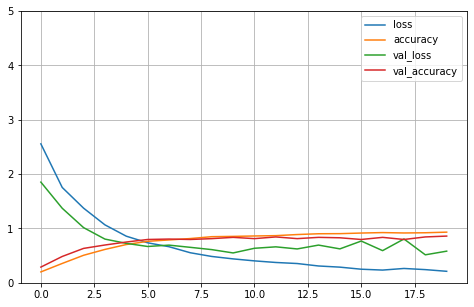

In [61]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()

## Model Inference

In [62]:
def pred_infer(image, img_height, img_width):
    img = keras.preprocessing.image.load_img(image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    print(f"Kayaknya hasilnya {class_names[np.argmax(score)]} persentasenya {np.max(score) * 100} %")
    return img

Kayaknya hasilnya kue_lapis persentasenya 100.0 %


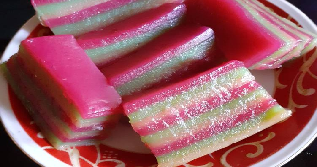

In [63]:
pred_infer('inference/kue-lapis-contoh.jpg',IMG_HEIGHT, IMG_WIDTH)

# Model Improvement

## Model VGG16 with fine-tuning

In [64]:
print("Number of layers in the base model: ", len(model_vgg16.layers))

Number of layers in the base model:  19


In [65]:
fine_tune_at = 10
for layer in model_vgg16.layers[:fine_tune_at]:
  layer.trainable =  False

In [66]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 167, 317, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 167, 317, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 9, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 9, 16)          73744     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 5, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 5, 32)          4640      
                                                             

In [68]:
len(model.trainable_variables)

10

In [69]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[es],)

Epoch 20/45
381/381 [==============================] - 16s 38ms/step - loss: 0.1949 - accuracy: 0.9422 - val_loss: 0.7076 - val_accuracy: 0.8516
Epoch 21/45
381/381 [==============================] - 15s 38ms/step - loss: 0.1744 - accuracy: 0.9416 - val_loss: 0.7636 - val_accuracy: 0.8594
Epoch 22/45
381/381 [==============================] - 15s 38ms/step - loss: 0.1671 - accuracy: 0.9521 - val_loss: 0.9699 - val_accuracy: 0.8359
Epoch 23/45
381/381 [==============================] - 15s 38ms/step - loss: 0.1907 - accuracy: 0.9462 - val_loss: 0.8399 - val_accuracy: 0.8438
Epoch 24/45
381/381 [==============================] - 15s 38ms/step - loss: 0.2061 - accuracy: 0.9422 - val_loss: 0.8389 - val_accuracy: 0.8359
Epoch 25/45
381/381 [==============================] - 15s 38ms/step - loss: 0.1281 - accuracy: 0.9586 - val_loss: 0.9131 - val_accuracy: 0.8672
Epoch 26/45
381/381 [==============================] - 15s 38ms/step - loss: 0.1479 - accuracy: 0.9554 - val_loss: 0.8245 - val_ac

## Classification Report Base Model + VGG16 and fine tuning

In [70]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 160 images belonging to 8 classes.


In [71]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [72]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

                  precision    recall  f1-score   support

kue_dadar_gulung       0.90      0.95      0.93        20
   kue_kastengel       0.95      0.82      0.88        22
      kue_klepon       1.00      1.00      1.00        20
       kue_lapis       0.91      1.00      0.95        20
      kue_lumpur       1.00      0.90      0.95        20
 kue_putri_salju       0.87      0.72      0.79        18
     kue_risoles       0.73      0.80      0.76        20
      kue_serabi       0.78      0.90      0.84        20

        accuracy                           0.89       160
       macro avg       0.89      0.89      0.89       160
    weighted avg       0.89      0.89      0.89       160



## Result Per Epoch

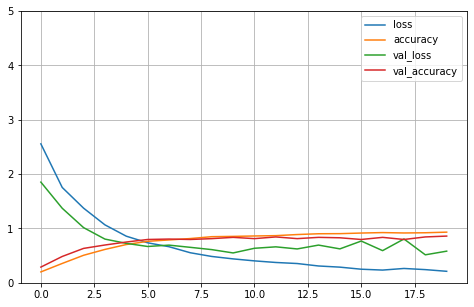

In [73]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()

## Model Inference

In [74]:
def pred_infer(image, img_height, img_width):
    img = keras.preprocessing.image.load_img(image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    print(f"Kayaknya hasilnya {class_names[np.argmax(score)]} persentasenya {np.max(score) * 100} %")
    return img

Kayaknya hasilnya kue_risoles persentasenya 70.53253054618835 %


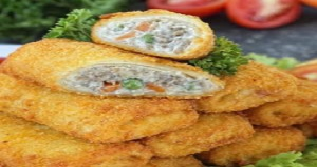

In [75]:
pred_infer('inference/risoles-sayur.jpg',IMG_HEIGHT, IMG_WIDTH)

In [76]:
model.save("my_h5_model.h5")

# Kesimpulan 

## Data Analysist

Data yaang diberikan untuk train model telah memberikan kejelasan yang cukup baik dari masing masing kelas, sehingga memberikan skor yang cukup tinggi pada masing masing kelas ketika dilakukan validasi dan model inference

## Model Analysist

### Base Model

Base model dinilai telah memberikan hasil yang cukup memuaskan, dengan pemilihan neuron dan activation function yang general (relu) dinilai telah cukup memberikan hasil yang baik dikarenakan dataset per kelas telah memberikan keterwakilan yang baik serga data yang cukup heterogen antar kelasnya
Untuk peningkatan dapat dilakukan pemilihan activation function yang lebih spesifik seperti Leaky Relu atau Parameterised Relu, namun tidak dilakukan karena hasil dinilai telah cukup memuaskan

### Base Model dengan TransferLearning dari VGG16

 VGG16 merupakan salah satu pretrained model dari dengan arsitektur yang sangat advance, dengan rata rata skor pada imagenet sebesar 92%, informasi yang transfer dari model tersebut telah membawa dampak sangat signifikan terhadap basemodel.


### Base Model dengan TransferLearning dari VGG16 + Fine tuning

Base model dengan tambahan transfer learning serta fine tuning terhadap 10 layer pertama dari VGG16 tidak memberikan dampak begitu positif karena pada model sebelumnya dinilai telah optimal. Perubahan optimizer pun tidak memberikan dampak yg signifikan karna informasi yg diberikan oleh VGG16 telah mendominasi model

> 